# Testing DESIGNR's truth table function 

In [1]:
import pandas as pd
import json
from dgd.utils.utils5 import *
from itertools import cycle
import matplotlib.cm as cm
import os
import networkx as nx
import pydot
import matplotlib.pyplot as plt
#import pygraphviz as pgv
import json5 as json  # Import json5 instead of json
import re

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_2521555/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
input_signals_list_binary_3_input = [
    {0: 0, 1: 0, 2: 0},  # First set of input signals
    {0: 0, 1: 0, 2: 1},  # Second set of input signals
    {0: 0, 1: 1, 2: 0},  # Third set of input signals
    {0: 0, 1: 1, 2: 1},  # First set of input signals
    {0: 1, 1: 0, 2: 0},  # Second set of input signals
    {0: 1, 1: 0, 2: 1},  # Third set of input signals    
    {0: 1, 1: 1, 2: 0},  # Second set of input signals
    {0: 1, 1: 1, 2: 1},  # Third set of input signals  
]   

input_signals_list_binary_4_input = [
    {0: 0, 1: 0, 2: 0, 3: 0},  
    {0: 0, 1: 0, 2: 0, 3: 1},  
    {0: 0, 1: 0, 2: 1, 3: 0}, 
    {0: 0, 1: 0, 2: 1, 3: 1}, 
    {0: 0, 1: 1, 2: 0, 3: 0},  
    {0: 0, 1: 1, 2: 0, 3: 1},    
    {0: 0, 1: 1, 2: 1, 3: 0},  
    {0: 0, 1: 1, 2: 1, 3: 1}, 
    {0: 1, 1: 0, 2: 0, 3: 0},  
    {0: 1, 1: 0, 2: 0, 3: 1},  
    {0: 1, 1: 0, 2: 1, 3: 0}, 
    {0: 1, 1: 0, 2: 1, 3: 1}, 
    {0: 1, 1: 1, 2: 0, 3: 0},  
    {0: 1, 1: 1, 2: 0, 3: 1},    
    {0: 1, 1: 1, 2: 1, 3: 0},  
    {0: 1, 1: 1, 2: 1, 3: 1},     
]   


In [4]:
def convert_folder_to_dags(folder_path):
    graphs = {}
    # Walk through each directory in the folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith("_outputNetlist.json"):
                full_path = os.path.join(root, file)
                print(f"Processing file: {full_path}")  # Print the file being processed
                data = load_json_file(full_path)
                graph = create_dag_from_json(data)
                # Use the directory name as the key for the graph
                dir_name = os.path.basename(root)
                graphs[dir_name] = graph
    return graphs

def load_json_file(filename):
    with open(filename, 'r') as file:
        file_content = file.read()
        # Fix trailing commas in JSON objects and arrays
        file_content = re.sub(r',(\s*[\]}])', r'\1', file_content)
        # Additional cleanup: Ensure no trailing commas at the end of the entire JSON content
        file_content = re.sub(r',\s*\Z', '', file_content)
        data = json.loads(file_content)
    return data

def create_dag_from_json(data):
    G = nx.DiGraph()
    # Add nodes to the graph
    for node in data['nodes']:
        G.add_node(node['name'], nodeType=node['nodeType'], deviceName=node['deviceName'])
    # Add edges to the graph
    for edge in data['edges']:
        G.add_edge(edge['src'], edge['dst'], name=edge['name'])
    return G



In [5]:
def topology_plot_with_attrs(G, node_attr = None, edge_attr = None, seed = 42):

    if node_attr is None:
        first_node_attrs = next(iter(G.nodes(data=True)), (None, {}))[1]
        node_attr = next(iter(first_node_attrs), None)

    if edge_attr is None:
        for _, _, d in G.edges(data=True):
            if d:
                edge_attr = next(iter(d))
                break

    pos = nx.spring_layout(G, seed=seed)
    plt.figure(figsize=(5, 5)); plt.axis("off")

    node_labels = {}
    default_colour = "lightblue"          
    node_colors   = default_colour

    if node_attr is not None:
        values = [G.nodes[n].get(node_attr) for n in G.nodes()]


        if all(isinstance(v, (int, float)) for v in values if v is not None):
            norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
            cmap = cm.get_cmap("viridis")
            node_colors = [cmap(norm(v)) for v in values]


        else:
            present_vals = {v for v in values if v is not None}

            unique_vals  = sorted(present_vals, key=lambda x: str(x))

            palette     = cycle(cm.tab20.colors)
            colour_map  = {val: next(palette) for val in unique_vals}
            missing_col = "#d3d3d3"                     # grey for None
            node_colors = [colour_map.get(v, missing_col) for v in values]


        for n in G.nodes():
            val = G.nodes[n].get(node_attr)
            node_labels[n] = f"{n}\n{node_attr}={val}"

    else:
        node_labels = {n: n for n in G.nodes()}


    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400)
    nx.draw_networkx_edges(G, pos, arrows=G.is_directed())
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    '''
    if edge_attr is not None:
        edge_labels = {
            (u, v): f"{edge_attr}={d.get(edge_attr)}"
            for u, v, d in G.edges(data=True) if edge_attr in d
        }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    '''

    if node_attr and not all(isinstance(v, (int, float)) for v in values if v is not None):
        handles = [
            plt.Line2D([0], [0], marker="o", color="w",
                       markerfacecolor=colour_map[val], markersize=8,
                       label=str(val))
            for val in unique_vals
        ]
        if any(v is None for v in values):
            handles.append(
                plt.Line2D([0], [0], marker="o", color="w",
                           markerfacecolor=missing_col, markersize=8,
                           label="None")
            )
        plt.legend(title=node_attr, handles=handles,
                   bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout(); plt.show()

In [6]:
def _json_node_index(json_data):
    """Map node name -> dict with nodeType and deviceName (from JSON only)."""
    return {
        n.get("name"): {
            "nodeType": n.get("nodeType"),
            "deviceName": n.get("deviceName"),
        }
        for n in json_data.get("nodes", [])
    }

def _parse_device_name(device_name):
    """
    Parse a Cello device name like 'B3_BM3R1' -> ('B3', 'BM3R1').
    Returns None for sensors/reporters/unset.
    """
    if not device_name:
        return None
    dn = device_name.lower()
    if "sensor" in dn or "reporter" in dn:
        return None
    parts = device_name.split("_")
    if len(parts) >= 2:
        return parts[0].strip(), parts[-1].strip()
    return None

def assign_parts_from_json_repressors(
    G: nx.DiGraph,
    json_data: dict,
    df: pd.DataFrame,
    *,
    topological_sort: bool = False,
    strict: bool = True,
    verbose: bool = False,
):
    """
    Assign part parameters to interior (non-IO) nodes by reading each node's
    deviceName from the Cello JSON and matching (RBS, Repressor) in `df`.

    - Inputs/outputs tagged via node['type'] in {'input','output'}.
    - Gate nodes get all columns from `df`, plus node['RBS'], node['Repressor'], node['type']='gate'.
    - Removes any existing 'nodeType' and 'deviceName' attributes from nodes.
    - Finally, relabels input nodes named in1, in2, ... to integers 0, 1, ...
      (only those matching the pattern; others left unchanged).
    - If verbose=True, prints detected IO, gate assignments, cleanup removals, and relabel mapping.
    """
    H = G.copy()
    jindex = _json_node_index(json_data)

    # Identify IO via JSON; fall back to degree if missing.
    input_nodes = {n for n, info in jindex.items() if info.get("nodeType") == "PRIMARY_INPUT"}
    output_nodes = {n for n, info in jindex.items() if info.get("nodeType") == "PRIMARY_OUTPUT"}
    if not input_nodes:
        input_nodes = {n for n in H.nodes if H.in_degree(n) == 0}
    if not output_nodes:
        output_nodes = {n for n in H.nodes if H.out_degree(n) == 0}

    if verbose:
        print("=== assign_parts_from_json_repressors: changes ===")
        print(f"[detect] inputs:  {list(input_nodes)}")
        print(f"[detect] outputs: {list(output_nodes)}")

    # Interior nodes
    non_io = [n for n in H.nodes if n not in input_nodes and n not in output_nodes]
    if topological_sort:
        non_io = [n for n in nx.topological_sort(H) if n in non_io]
    else:
        non_io = sorted(non_io)

    # Validate df & build lookup {(RBS, Repressor)->row}
    if "Repressor" not in df.columns or "RBS" not in df.columns:
        raise ValueError("DataFrame must contain 'Repressor' and 'RBS' columns.")
    key_to_idx = {
        (str(row["RBS"]).upper().strip(), str(row["Repressor"]).lower().strip()): i
        for i, row in df.iterrows()
    }

    # Tag IO types
    for n in input_nodes:
        H.nodes[n]["type"] = "input"
    for n in output_nodes:
        H.nodes[n]["type"] = "output"

    # Assign gate params
    for n in non_io:
        device_name = (jindex.get(n) or {}).get("deviceName")
        parsed = _parse_device_name(device_name)
        if parsed is None:
            if strict:
                raise ValueError(f"Node '{n}' has unparseable or unsupported deviceName: {device_name}")
            else:
                if verbose:
                    print(f"[skip ] {n}: unparseable/unsupported deviceName '{device_name}'")
                continue

        rbs, repressor = parsed
        key = (rbs.upper(), repressor.lower())
        if key not in key_to_idx:
            if strict:
                raise ValueError(f"No match in df for node '{n}' with (RBS='{rbs}', Repressor='{repressor}').")
            else:
                if verbose:
                    print(f"[skip ] {n}: no df match for (RBS='{rbs}', Repressor='{repressor}')")
                continue

        idx = key_to_idx[key]
        row = df.loc[idx]
        for col in df.columns:
            H.nodes[n][col] = row[col]
        H.nodes[n]["RBS"] = rbs
        H.nodes[n]["Repressor"] = repressor
        H.nodes[n]["type"] = "gate"

        if verbose:
            print(f"[assign] {n}: deviceName='{device_name}' -> RBS='{rbs}', Repressor='{repressor}' (df row {idx})")

    # Remove legacy attributes from ALL nodes (track removals)
    removed_any = False
    for n in H.nodes:
        removed = []
        if "nodeType" in H.nodes[n]:
            H.nodes[n].pop("nodeType", None)
            removed.append("nodeType")
        if "deviceName" in H.nodes[n]:
            H.nodes[n].pop("deviceName", None)
            removed.append("deviceName")
        if verbose and removed:
            removed_any = True
            print(f"[cleanup] {n}: removed {removed}")
    if verbose and not removed_any:
        print("[cleanup] no 'nodeType'/'deviceName' attributes were present on nodes")

    # === Relabel inputs: in1->0, in2->1, in3->2, in4->3 (ints) ===
    pattern = re.compile(r'^(?:in|IN)(\d+)$')
    mapping = {}
    for name in list(input_nodes):
        m = pattern.match(str(name))
        if not m:
            continue  # only rename inX-style inputs
        k = int(m.group(1))
        new_label = k - 1  # zero-based: in1 -> 0
        if new_label in H and new_label != name:
            raise ValueError(f"Cannot relabel '{name}' to {new_label}: label already exists.")
        mapping[name] = new_label

    if mapping:
        if verbose:
            for old, new in mapping.items():
                print(f"[relabel] {old} -> {new}")
        H = nx.relabel_nodes(H, mapping, copy=True)
    else:
        if verbose:
            print("[relabel] no input relabeling performed")

    if verbose:
        print("=== end ===")

    return H

import re
import networkx as nx

import re
import networkx as nx

def assign_io_from_json(
    G: nx.DiGraph,
    json_data: dict,
    *,
    fallback_by_degree: bool = True,
    relabel_inputs: bool = True,
    verbose: bool = False,
):
    """
    Tag IO nodes using Cello-like JSON (nodeType PRIMARY_INPUT/PRIMARY_OUTPUT), with
    robust name matching and degree-based augmentation.

    - Sets node['type'] = 'input' / 'output' for detected IO nodes.
    - Leaves non-IO nodes' attributes untouched (no gate assignments).
    - Cleans legacy attributes ('nodeType', 'deviceName') from ALL nodes.
    - Optionally relabels input nodes named in1,in2,... to integers 0,1,2,... (zero-based).
    - Returns a *copy* of G with updates.

    Robustness:
    - Accepts common JSON shapes: {"nodes":[...]}, {"design":{"nodes":[...]}}, or a
      mapping-like dict of label->info.
    - Name matching is case/whitespace tolerant (strip + lower).
    - Fallback via degree **augments** JSON-detected IO (does not replace), so a single
      missed input like 'in4' is still captured when it has in-degree==0.
    """

    def _index_nodes(j):
        """Map: node_label -> node_json_dict for common JSON shapes."""
        idx = {}
        if isinstance(j, dict):
            if isinstance(j.get("nodes"), list):
                cand = j["nodes"]
            elif isinstance(j.get("design"), dict) and isinstance(j["design"].get("nodes"), list):
                cand = j["design"]["nodes"]
            elif j and all(isinstance(v, dict) for v in j.values()):
                # Mapping of label->info
                for k, v in j.items():
                    idx[str(k)] = v
                return idx
            else:
                cand = []
            for nd in cand:
                key = nd.get("name") or nd.get("id") or nd.get("label") or nd.get("ref") or nd.get("node")
                if key is not None:
                    idx[str(key)] = nd
        return idx

    def _norm(x):
        return str(x).strip().lower() if x is not None else None

    H = G.copy()
    jindex = _index_nodes(json_data)

    # --- 1) Detect IO via JSON (normalize names to avoid case/space mismatches)
    json_inputs_raw  = {k for k, info in jindex.items()
                        if str(info.get("nodeType", "")).upper() == "PRIMARY_INPUT"}
    json_outputs_raw = {k for k, info in jindex.items()
                        if str(info.get("nodeType", "")).upper() == "PRIMARY_OUTPUT"}

    json_inputs_norm  = {_norm(k) for k in json_inputs_raw}
    json_outputs_norm = {_norm(k) for k in json_outputs_raw}

    # Normalize graph labels once
    label_norm = {n: _norm(n) for n in H.nodes}

    # Start with JSON-detected IO that actually exist in the graph (by normalized name)
    input_nodes  = {n for n, v in label_norm.items() if v in json_inputs_norm}
    output_nodes = {n for n, v in label_norm.items() if v in json_outputs_norm}

    # --- 2) Fallback via degree (AUGMENT, don't replace)
    if fallback_by_degree:
        deg_inputs  = {n for n in H.nodes if H.in_degree(n) == 0}
        deg_outputs = {n for n in H.nodes if H.out_degree(n) == 0}

        # Also include any string-named inputs like "in4" / "IN 4" etc.
        p_named = re.compile(r'^(?:in|IN)[ _]?(\d+)$')
        named_inputs = {n for n in H.nodes if isinstance(n, str) and p_named.match(n)}

        input_nodes  |= (deg_inputs | named_inputs)
        output_nodes |= deg_outputs

        # Ensure disjointness: an isolated node shouldn't be both
        output_nodes -= input_nodes

    if verbose:
        def show(x): return repr(x)  # reveals trailing spaces if any
        print("=== assign_io_from_json: changes ===")
        print(f"[detect] JSON inputs (raw):  {sorted(map(show, json_inputs_raw))}")
        print(f"[detect] JSON outputs (raw): {sorted(map(show, json_outputs_raw))}")
        print(f"[detect] inputs (final):  {sorted(map(show, input_nodes), key=str)}")
        print(f"[detect] outputs (final): {sorted(map(show, output_nodes), key=str)}")
        if fallback_by_degree:
            print(f"[debug ] deg-in==0:  {sorted(map(show, (n for n in H.nodes if H.in_degree(n)==0)), key=str)}")
            print(f"[debug ] deg-out==0: {sorted(map(show, (n for n in H.nodes if H.out_degree(n)==0)), key=str)}")

    # --- 3) Tag IO types
    for n in input_nodes:
        H.nodes[n]["type"] = "input"
    for n in output_nodes:
        H.nodes[n]["type"] = "output"

    # --- 4) Clean up legacy per-node attributes everywhere
    removed_any = False
    for n in H.nodes:
        removed = []
        if "nodeType" in H.nodes[n]:
            H.nodes[n].pop("nodeType", None)
            removed.append("nodeType")
        if "deviceName" in H.nodes[n]:
            H.nodes[n].pop("deviceName", None)
            removed.append("deviceName")
        if verbose and removed:
            removed_any = True
            print(f"[cleanup] {n!r}: removed {removed}")
    if verbose and not removed_any:
        print("[cleanup] no 'nodeType'/'deviceName' attributes were present on nodes")

    # --- 5) Optional: relabel inputs in1->0, in2->1, ... (zero-based)
    if relabel_inputs and input_nodes:
        p_relabel = re.compile(r'^(?:in|IN)[ _]?(\d+)$')
        mapping = {}
        for name in list(input_nodes):
            if not isinstance(name, str):
                continue
            m = p_relabel.match(name)
            if not m:
                continue
            new_label = int(m.group(1)) - 1  # zero-based: in1 -> 0
            if new_label in H and new_label != name:
                raise ValueError(f"Cannot relabel '{name}' to {new_label}: label already exists.")
            mapping[name] = new_label

        if mapping:
            if verbose:
                for old, new in sorted(mapping.items(), key=lambda x: str(x[0])):
                    print(f"[relabel] {old!r} -> {new!r}")
            H = nx.relabel_nodes(H, mapping, copy=True)
        elif verbose:
            print("[relabel] no input relabeling performed")

    if verbose:
        print("=== end ===")

    return H

In [7]:
def _outval(v):
    """Accept (0,), [0], or 0 -> int 0/1."""
    if isinstance(v, (tuple, list)):
        return int(v[0])
    return int(v)

def _seq_from_sim(sim_list):
    """[{'out':0}, ...] or [0,1,...] -> [0/1,...]."""
    return [
        int(next(iter(d.values()))) if isinstance(d, dict) else int(d)
        for d in sim_list
    ]

def _seq_from_tt(tt_dict):
    """Ordered dict of {(a,b,c): (0,), ...} -> [0/1,...] using current insertion order."""
    return [_outval(v) for v in tt_dict.values()]

def _bits_from_hex(hex_str, nrows, msb_first=True):
    """Return nrows bits from hex string; no reordering beyond MSB/LSB choice."""
    i = int(hex_str, 16)
    s = f"{i:0{nrows}b}"
    bits = [int(ch) for ch in s]
    return bits if msb_first else bits[::-1]

def _print_table(headers, rows):
    widths = [max(len(str(h)), max((len(str(r[i])) for r in rows), default=0))
              for i, h in enumerate(headers)]
    fmt = " | ".join(f"{{:{w}}}" for w in widths)
    sep = "-+-".join("-" * w for w in widths)
    print(fmt.format(*headers))
    print(sep)
    for r in rows:
        print(fmt.format(*r))


import math
import re
from itertools import product

def report_truth_table_ordered(
    design_name,
    sim_result  = None,
    tt1 = None,
    tt2  = None,
    hex_str = None,
    input_names = None,
    msb_first_hex  = True,
):
    """
    Print a row-aligned comparison table using whichever sources are provided
    (sim_result, tt1, tt2, hex_str), and return summary stats.

    Assumptions:
    - All provided sources are already aligned row-by-row (same order).
    - If tt1 or tt2 is provided and its keys are tuples, that defines the row labels.
    - If no TT is provided, row labels are generated from nrows if it's a power of two;
      otherwise row indices are used.

    Returns:
      {
        'design': str,
        'nrows': int,
        'n_compared_rows': int,     # rows where >=2 sources were present
        'n_ok': int,                # rows where all present sources agree
        'pct_ok': float | None,     # None if n_compared_rows == 0
        'all_equal': bool | None,   # None if n_compared_rows == 0
        'columns': [str,...],       # which columns were included
      }
    """

    # ---- helpers (use your existing _seq_from_sim/_seq_from_tt/_print_table) ----
    def _norm_hex_digits(s: str) -> str:
        """Extract leading hex run after optional 0x prefix; tolerant of suffixes."""
        m = re.match(r'^\s*(?:0[xX])?([0-9A-Fa-f]+)', str(s))
        if not m:
            raise ValueError(f"Couldn't parse hex digits from {s!r}")
        return m.group(1)

    def _bits_from_hex_auto(hex_str_local, nrows_hint, msb_first=True):
        """Return (bits, nrows_used). If nrows_hint is None, derive nrows from hex length."""
        hexdigits = _norm_hex_digits(hex_str_local)
        i = int(hexdigits, 16)
        if nrows_hint is None:
            nrows_used = 4 * len(hexdigits)  # each hex nibble = 4 bits
        else:
            nrows_used = nrows_hint
        # Safety: don't overflow; left-pad to nrows_used
        bitlen = max(1, i.bit_length())
        if bitlen > nrows_used:
            raise ValueError(
                f"Hex '{hexdigits}' encodes {bitlen} bits but expected <= {nrows_used}."
            )
        s = f"{i:0{nrows_used}b}"
        bits = [int(ch) for ch in s]
        return (bits if msb_first else bits[::-1], nrows_used)

    # ---- figure out nrows from whichever sources are present ----
    candidates = set()
    if tt1 is not None:
        candidates.add(len(tt1))
    if tt2 is not None:
        candidates.add(len(tt2))
    if sim_result is not None:
        candidates.add(len(sim_result))
    nrows_hex = None
    if hex_str is not None:
        nrows_hex = 4 * len(_norm_hex_digits(hex_str))
        candidates.add(nrows_hex)

    if not candidates:
        # nothing to compare; print a stub and return
        print(f"\n=== {design_name} ===")
        print("(No sources provided: sim_result/tt1/tt2/hex_str are all None)")
        return {
            "design": design_name,
            "nrows": 0,
            "n_compared_rows": 0,
            "n_ok": 0,
            "pct_ok": None,
            "all_equal": None,
            "columns": [],
        }

    if len(candidates) > 1:
        raise ValueError(f"Inconsistent row counts across sources: {sorted(candidates)}")
    nrows = candidates.pop()

    # ---- build row labels ----
    # Prefer tuple keys from a provided truth table (tt1 then tt2)
    input_rows = None
    if tt1 is not None:
        keys = list(tt1.keys())
        if keys and isinstance(keys[0], tuple):
            input_rows = keys
    if input_rows is None and tt2 is not None:
        keys = list(tt2.keys())
        if keys and isinstance(keys[0], tuple):
            input_rows = keys

    # If no tuple labels, try to synthesize from nrows (if power of two),
    # with A as MSB, D as LSB, etc.
    n_inputs = None
    if input_rows is None:
        # Check if nrows is a power of two
        if nrows > 0 and (nrows & (nrows - 1)) == 0:
            n_inputs = int(math.log2(nrows))
            # A is most significant (slowest-changing)
            input_rows = [tuple(p) for p in product([0, 1], repeat=n_inputs)]
        else:
            # Fall back to plain indices
            input_rows = list(range(nrows))

    if n_inputs is None:
        # If we used tuple labels, infer arity
        if input_rows and isinstance(input_rows[0], tuple):
            n_inputs = len(input_rows[0])
        else:
            n_inputs = 0  # unknown / not tuple-style

    # ---- gather column data only for provided sources ----
    columns = []     # names for headers
    col_values = []  # list of lists, each length == nrows

    if sim_result is not None:
        sim_vals = _seq_from_sim(sim_result)
        if len(sim_vals) != nrows:
            raise ValueError(f"sim_result length {len(sim_vals)} != expected nrows {nrows}")
        columns.append("Sim")
        col_values.append(sim_vals)

    if tt1 is not None:
        tt1_vals = _seq_from_tt(tt1)
        if len(tt1_vals) != nrows:
            raise ValueError(f"tt1 length {len(tt1_vals)} != expected nrows {nrows}")
        columns.append("TT1")
        col_values.append(tt1_vals)

    if tt2 is not None:
        tt2_vals = _seq_from_tt(tt2)
        if len(tt2_vals) != nrows:
            raise ValueError(f"tt2 length {len(tt2_vals)} != expected nrows {nrows}")
        columns.append("TT2")
        col_values.append(tt2_vals)

    if hex_str is not None:
        hex_vals, nrows_used = _bits_from_hex_auto(hex_str, nrows_hint=nrows, msb_first=msb_first_hex)
        if len(hex_vals) != nrows:
            raise ValueError(f"hex length {len(hex_vals)} != expected nrows {nrows}")
        columns.append("Hex")
        col_values.append(hex_vals)

    # ---- headers ----
    if input_names is None and n_inputs and n_inputs > 0:
        input_names = [chr(ord("A") + i) for i in range(n_inputs)]
    elif input_names is None:
        input_names = []  # no input columns if we don't have tuple labels

    headers = list(input_names) + columns + (["Row OK?"] if len(columns) >= 2 else [])

    # ---- build rows & OK mask ----
    n_compared_rows = 0
    n_ok = 0
    rows = []
    for i in range(nrows):
        # Input label cells
        if isinstance(input_rows[i], tuple):
            row_cells = list(input_rows[i])
        else:
            row_cells = [input_rows[i]] if input_names else []

        # Col values for this row
        vals_i = [col[i] for col in col_values]

        # Decide OK? (only if we have >=2 sources)
        ok_cell = None
        if len(vals_i) >= 2:
            n_compared_rows += 1
            if all(v == vals_i[0] for v in vals_i[1:]):
                ok_cell = "OK"
                n_ok += 1
            else:
                ok_cell = "DIFF"

        row_cells.extend(vals_i)
        if ok_cell is not None:
            row_cells.append(ok_cell)

        rows.append(row_cells)

    pct_ok = (100.0 * n_ok / n_compared_rows) if n_compared_rows else None
    all_equal = (n_ok == n_compared_rows) if n_compared_rows else None

    # ---- print ----
    print(f"\n=== {design_name} ===")
    _print_table(headers, rows)
    if n_compared_rows:
        print(f"Agreement for {design_name}: {n_ok}/{n_compared_rows} rows = {pct_ok:.2f}%")
    else:
        print(f"Agreement for {design_name}: N/A (need at least two sources)")

    return {
        "design": design_name,
        "nrows": nrows,
        "n_compared_rows": n_compared_rows,
        "n_ok": n_ok,
        "pct_ok": pct_ok,
        "all_equal": all_equal,
        "columns": columns,
    }
    
def _detect_output_nodes(G):
    # 1) Prefer nodes tagged as outputs
    outs = [n for n, d in G.nodes(data=True) if d.get("type") == "output"]
    # 2) Otherwise prefer a node literally named 'out'
    if not outs and "out" in G:
        outs = ["out"]
    # 3) Otherwise, use nodes with out-degree == 0
    if not outs:
        outs = [n for n in G.nodes if G.out_degree(n) == 0]
    return outs


In [8]:
"""
Generates Verilog for all 3-input 1-output circuits (except 00 and FF)
with the Wolfram naming scheme. You probably don't need to run this.
"""

__author__ = 'Timothy S. Jones <jonests@bu.edu>, Densmore Lab, BU'
__license__ = 'GPL3'

import os

verilog = """module m0x{name}(output out, input in1, in2, in3);

   always @(in1, in2, in3)
     begin
        case({{in1, in2, in3}})
          3'b000: {{out}} = 1'b{b[0]};
          3'b001: {{out}} = 1'b{b[1]};
          3'b010: {{out}} = 1'b{b[2]};
          3'b011: {{out}} = 1'b{b[3]};
          3'b100: {{out}} = 1'b{b[4]};
          3'b101: {{out}} = 1'b{b[5]};
          3'b110: {{out}} = 1'b{b[6]};
          3'b111: {{out}} = 1'b{b[7]};
        endcase // case ({{in1, in2, in3}})
     end // always @ (in1, in2, in3)

endmodule // m0x{name}"""

#### Code for importing a Cello 2.0 design (3 input) into DESIGNR and score it

Nodes in the DAG:
('$1', {'nodeType': 'NOR', 'deviceName': 'L1_LitR'})
('out', {'nodeType': 'PRIMARY_OUTPUT', 'deviceName': 'YFP_reporter'})
('$2', {'nodeType': 'NOR', 'deviceName': 'B1_BM3R1'})
('$3', {'nodeType': 'NOT', 'deviceName': 'R1_PsrA'})
('$4', {'nodeType': 'NOR', 'deviceName': 'Q2_QacR'})
('in4', {'nodeType': 'PRIMARY_INPUT', 'deviceName': 'BetI_sensor'})
('$5', {'nodeType': 'NOT', 'deviceName': 'P1_PhlF'})
('in3', {'nodeType': 'PRIMARY_INPUT', 'deviceName': 'LacI_sensor'})
('$6', {'nodeType': 'NOT', 'deviceName': 'A1_AmtR'})
('$7', {'nodeType': 'NOT', 'deviceName': 'S4_SrpR'})
('in2', {'nodeType': 'PRIMARY_INPUT', 'deviceName': 'TetR_sensor'})
('in1', {'nodeType': 'PRIMARY_INPUT', 'deviceName': 'AraC_sensor'})

Edges in the DAG:
('$1', 'out', {'name': 'e1__$1_out'})
('$2', '$1', {'name': 'e2__$2_$1'})
('$3', '$1', {'name': 'e3__$3_$1'})
('$4', '$3', {'name': 'e4__$4_$3'})
('in4', '$2', {'name': 'e5__in4_$2'})
('$5', '$2', {'name': 'e6__$5_$2'})
('in3', '$5', {'name': 'e7__i

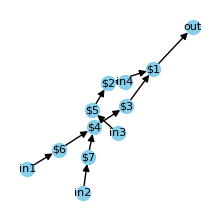

In [9]:
# Path to the JSON file
json_file_path = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs/0x000D_V2/0x000D_V2_outputNetlist.json'


# Load JSON data from file
json_data = load_json_file(json_file_path)

# Create a DAG from the JSON data
dag = create_dag_from_json(json_data)

# Print the nodes and edges in the DAG
print("Nodes in the DAG:")
for node in dag.nodes(data=True):
    print(node)

print("\nEdges in the DAG:")
for edge in dag.edges(data=True):
    print(edge)
    
G = dag

plt.figure(figsize=(2, 2))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, 
        edge_color='k', linewidths=1, font_size=8, 
        arrows=True, arrowsize=10)
plt.show()      

=== assign_io_from_json: changes ===
[detect] JSON inputs (raw):  ["'in1'", "'in2'", "'in3'", "'in4'"]
[detect] JSON outputs (raw): ["'out'"]
[detect] inputs (final):  ["'in1'", "'in2'", "'in3'", "'in4'"]
[detect] outputs (final): ["'out'"]
[debug ] deg-in==0:  ["'in1'", "'in2'", "'in3'", "'in4'"]
[debug ] deg-out==0: ["'out'"]
[cleanup] '$1': removed ['nodeType', 'deviceName']
[cleanup] 'out': removed ['nodeType', 'deviceName']
[cleanup] '$2': removed ['nodeType', 'deviceName']
[cleanup] '$3': removed ['nodeType', 'deviceName']
[cleanup] '$4': removed ['nodeType', 'deviceName']
[cleanup] 'in4': removed ['nodeType', 'deviceName']
[cleanup] '$5': removed ['nodeType', 'deviceName']
[cleanup] 'in3': removed ['nodeType', 'deviceName']
[cleanup] '$6': removed ['nodeType', 'deviceName']
[cleanup] '$7': removed ['nodeType', 'deviceName']
[cleanup] 'in2': removed ['nodeType', 'deviceName']
[cleanup] 'in1': removed ['nodeType', 'deviceName']
[relabel] 'in1' -> 0
[relabel] 'in2' -> 1
[relabel] '

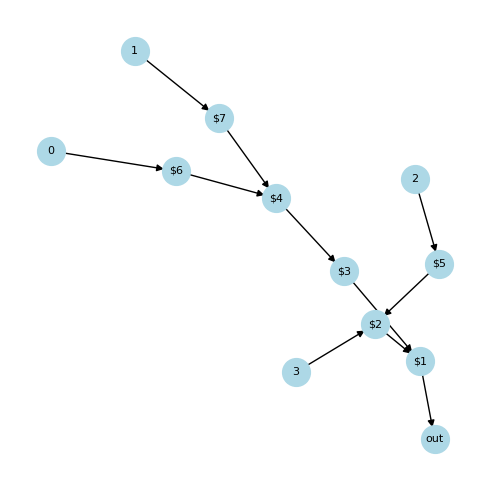

In [10]:
G_assigned = assign_io_from_json(G, json_data, verbose = True)
        
for attr in G_assigned.nodes(data=True):
    print(attr)

topology_plot_with_attrs(G_assigned, seed = 1459)

#### Code for analyzing a 3-input dataset

In [11]:
folder_path = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs_3_input'

cello_designs_gates_assigned_3_input = {}
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith("_outputNetlist.json"):
            full_path = os.path.join(root, file)
            print(f"Processing file: {full_path}")  # Print the file being processed
            data = load_json_file(full_path)
            graph = create_dag_from_json(data)
            
            nodes_with_no_incoming_edges = [n for n in graph.nodes() if graph.in_degree(n) == 0]
            
            if len(nodes_with_no_incoming_edges) != 3:
                print("[INFO] Design does not have 3 inputs")
                continue
            
            try:
                #graph_parts_assigned = assign_parts_from_json_repressors(graph, data, cello_v1_hill_function_parameters, topological_sort=False, verbose=False, strict=False)
                graph_parts_assigned = assign_io_from_json(graph, json_data, verbose = False)
            except ValueError:
                print("Value Error")
                continue
            except Exception as e:
                print(f"[ERROR] Unexpected error while assigning parts: {e}")
                continue           
            
            # Use the directory name as the key for the graph
            dir_name = os.path.basename(root)
            #topology_plot_with_attrs(graph_parts_assigned, seed = 1459)
            cello_designs_gates_assigned_3_input[dir_name] = graph_parts_assigned


Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs_3_input/0x26/0x26_outputNetlist.json


Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs_3_input/0x3D/0x3D_outputNetlist.json
Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs_3_input/0x27/0x27_outputNetlist.json
Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs_3_input/0x1F/0x1F_outputNetlist.json
Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs_3_input/0x80/0x80_outputNetlist.json
Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs_3_input/0x4D/0x4D_outputNetlist.json
Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs_3_input/0x87/0x87_outputNetlist.jso

In [12]:
print(len(cello_designs_gates_assigned_3_input))
cello_designs_gates_assigned_3_input

108


{'0x26': <networkx.classes.digraph.DiGraph at 0x7f6897088d60>,
 '0x3D': <networkx.classes.digraph.DiGraph at 0x7f6897088b80>,
 '0x27': <networkx.classes.digraph.DiGraph at 0x7f68970d7e20>,
 '0x1F': <networkx.classes.digraph.DiGraph at 0x7f6ad6f731f0>,
 '0x80': <networkx.classes.digraph.DiGraph at 0x7f6897088e80>,
 '0x4D': <networkx.classes.digraph.DiGraph at 0x7f6897081c70>,
 '0x87': <networkx.classes.digraph.DiGraph at 0x7f689f29a640>,
 '0x2B': <networkx.classes.digraph.DiGraph at 0x7f6ad6f73190>,
 '0x7A': <networkx.classes.digraph.DiGraph at 0x7f68970d7e80>,
 '0x37': <networkx.classes.digraph.DiGraph at 0x7f689f29a0a0>,
 '0x20': <networkx.classes.digraph.DiGraph at 0x7f68970d7ee0>,
 '0x84': <networkx.classes.digraph.DiGraph at 0x7f689f29a9d0>,
 '0x7F': <networkx.classes.digraph.DiGraph at 0x7f689f29ad90>,
 '0x25': <networkx.classes.digraph.DiGraph at 0x7f68970422e0>,
 '0x07': <networkx.classes.digraph.DiGraph at 0x7f6897088e20>,
 '0x24': <networkx.classes.digraph.DiGraph at 0x7f689f2

In [13]:
summaries = []
for cello_circuit_hex, design in cello_designs_gates_assigned_3_input.items():
    sim = simulate_signal_propagation_binary(design, input_signals_list_binary_3_input)
    tt1 = calculate_truth_table(design)
    tt2 = calculate_truth_table_v2(design)

    stats = report_truth_table_ordered(
        design_name=f"Design {cello_circuit_hex}",
        sim_result=sim,
        #tt1=tt1,
        tt2=tt2,
        hex_str=cello_circuit_hex.split('_', 1)[0],
        input_names=["A", "B", "C"],
        msb_first_hex=True
    )

    # --- add output indegree info ---
    outs = _detect_output_nodes(design)
    indeg_map = {n: design.in_degree(n) for n in outs}
    if len(outs) == 1:
        stats["out_node"] = outs[0]
        stats["out_indegree"] = indeg_map[outs[0]]
    else:
        stats["out_node"] = None         # multiple or none
        stats["out_indegree"] = None
    stats["out_indegree_map"] = indeg_map  # keeps full detail if multiple

    summaries.append(stats)

# --- DESIGN-LEVEL SUMMARY ---
designs_total = len(summaries)
designs_ok = sum(1 for s in summaries if s["all_equal"])
pct_designs_ok = 100.0 * designs_ok / designs_total if designs_total else 0.0

# Build rows: include output indegree
def _fmt_out_indegree(s):
    if s["out_node"] is not None:
        return f"{s['out_node']} (in={s['out_indegree']})"
    if s["out_indegree_map"]:
        # multiple outputs: show compact map
        return ", ".join(f"{n}={k}" for n, k in s["out_indegree_map"].items())
    return "N/A"

design_rows = [
    [s["design"], "Yes" if s["all_equal"] else "No", _fmt_out_indegree(s)]
    for s in summaries
]
_print_table(["Design", "All Rows Match?", "Output indegree"], design_rows)

print(f"\nPERCENT OF DESIGNS FULLY MATCHING: {designs_ok}/{designs_total} ({pct_designs_ok:.2f}%)")



=== Design 0x26 ===
A | B | C | Sim | TT2 | Hex | Row OK?
--+---+---+-----+-----+-----+--------
0 | 0 | 0 |   0 |   0 |   0 | OK     
0 | 0 | 1 |   0 |   0 |   0 | OK     
0 | 1 | 0 |   1 |   1 |   1 | OK     
0 | 1 | 1 |   0 |   0 |   0 | OK     
1 | 0 | 0 |   0 |   0 |   0 | OK     
1 | 0 | 1 |   1 |   1 |   1 | OK     
1 | 1 | 0 |   1 |   1 |   1 | OK     
1 | 1 | 1 |   0 |   0 |   0 | OK     
Agreement for Design 0x26: 8/8 rows = 100.00%

=== Design 0x3D ===
A | B | C | Sim | TT2 | Hex | Row OK?
--+---+---+-----+-----+-----+--------
0 | 0 | 0 |   0 |   0 |   0 | OK     
0 | 0 | 1 |   0 |   0 |   0 | OK     
0 | 1 | 0 |   1 |   1 |   1 | OK     
0 | 1 | 1 |   1 |   1 |   1 | OK     
1 | 0 | 0 |   1 |   1 |   1 | OK     
1 | 0 | 1 |   1 |   1 |   1 | OK     
1 | 1 | 0 |   0 |   0 |   0 | OK     
1 | 1 | 1 |   1 |   1 |   1 | OK     
Agreement for Design 0x3D: 8/8 rows = 100.00%

=== Design 0x27 ===
A | B | C | Sim | TT2 | Hex | Row OK?
--+---+---+-----+-----+-----+--------
0 | 0 | 0

In [14]:
#stop

#### Code for analyzing a 4-input dataset 

In [15]:
folder_path = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs'

cello_designs_gates_assigned_4_input = {}
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith("_outputNetlist.json"):
            full_path = os.path.join(root, file)
            print(f"Processing file: {full_path}")  # Print the file being processed
            data = load_json_file(full_path)
            graph = create_dag_from_json(data)
            
            nodes_with_no_incoming_edges = [n for n in graph.nodes() if graph.in_degree(n) == 0]
            
            if len(nodes_with_no_incoming_edges) != 4:
                print("[INFO] Design does not have 3 inputs")
                continue
            
            try:
                graph_parts_assigned = assign_io_from_json(graph, json_data, fallback_by_degree=True, verbose = False)
                #graph_parts_assigned = assign_parts_from_json_repressors(graph, data, cello_v1_hill_function_parameters, topological_sort=False, verbose=False, strict=False)
            except ValueError:
                print("Value Error")
                continue
            except Exception as e:
                print(f"[ERROR] Unexpected error while assigning parts: {e}")
                continue           
            
            # Use the directory name as the key for the graph
            dir_name = os.path.basename(root)
            #topology_plot_with_attrs(graph_parts_assigned, seed = 1459)
            cello_designs_gates_assigned_4_input[dir_name] = graph_parts_assigned

Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs/0x23CF_V2/0x23CF_V2_outputNetlist.json
Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs/0x1CBF_V2/0x1CBF_V2_outputNetlist.json
Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs/0x41A2_V2/0x41A2_V2_outputNetlist.json
Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs/0x00EF_V2/0x00EF_V2_outputNetlist.json
Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs/0xE677_V2/0xE677_V2_outputNetlist.json
Processing file: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/Cello_2_designs/0x00DF_V2/0x00DF_V2_outpu

In [16]:
len(cello_designs_gates_assigned_4_input)

43

In [17]:
summaries = []
for cello_circuit_hex, design in cello_designs_gates_assigned_4_input.items():
    sim = simulate_signal_propagation_binary(design, input_signals_list_binary_4_input)
    tt1 = calculate_truth_table(design)
    tt2 = calculate_truth_table_v2(design)

    stats = report_truth_table_ordered(
        design_name=f"Design {cello_circuit_hex}",
        sim_result=sim,
        #tt1=tt1,
        tt2=tt2,
        hex_str=cello_circuit_hex.split('_', 1)[0],
        input_names=["A", "B", "C", "D"],
        msb_first_hex=True
    )

    # --- add output indegree info ---
    outs = _detect_output_nodes(design)
    indeg_map = {n: design.in_degree(n) for n in outs}
    if len(outs) == 1:
        stats["out_node"] = outs[0]
        stats["out_indegree"] = indeg_map[outs[0]]
    else:
        stats["out_node"] = None         # multiple or none
        stats["out_indegree"] = None
    stats["out_indegree_map"] = indeg_map  # keeps full detail if multiple

    summaries.append(stats)

# --- DESIGN-LEVEL SUMMARY ---
designs_total = len(summaries)
designs_ok = sum(1 for s in summaries if s["all_equal"])
pct_designs_ok = 100.0 * designs_ok / designs_total if designs_total else 0.0

# Build rows: include output indegree
def _fmt_out_indegree(s):
    if s["out_node"] is not None:
        return f"{s['out_node']} (in={s['out_indegree']})"
    if s["out_indegree_map"]:
        # multiple outputs: show compact map
        return ", ".join(f"{n}={k}" for n, k in s["out_indegree_map"].items())
    return "N/A"

design_rows = [
    [s["design"], "Yes" if s["all_equal"] else "No", _fmt_out_indegree(s)]
    for s in summaries
]
_print_table(["Design", "All Rows Match?", "Output indegree"], design_rows)

print(f"\nPERCENT OF DESIGNS FULLY MATCHING: {designs_ok}/{designs_total} ({pct_designs_ok:.2f}%)")



=== Design 0x23CF_V2 ===
A | B | C | D | Sim | TT2 | Hex | Row OK?
--+---+---+---+-----+-----+-----+--------
0 | 0 | 0 | 0 |   0 |   0 |   0 | OK     
0 | 0 | 0 | 1 |   0 |   0 |   0 | OK     
0 | 0 | 1 | 0 |   1 |   1 |   1 | OK     
0 | 0 | 1 | 1 |   0 |   0 |   0 | OK     
0 | 1 | 0 | 0 |   0 |   0 |   0 | OK     
0 | 1 | 0 | 1 |   0 |   0 |   0 | OK     
0 | 1 | 1 | 0 |   1 |   1 |   1 | OK     
0 | 1 | 1 | 1 |   1 |   1 |   1 | OK     
1 | 0 | 0 | 0 |   1 |   1 |   1 | OK     
1 | 0 | 0 | 1 |   1 |   1 |   1 | OK     
1 | 0 | 1 | 0 |   0 |   0 |   0 | OK     
1 | 0 | 1 | 1 |   0 |   0 |   0 | OK     
1 | 1 | 0 | 0 |   1 |   1 |   1 | OK     
1 | 1 | 0 | 1 |   1 |   1 |   1 | OK     
1 | 1 | 1 | 0 |   1 |   1 |   1 | OK     
1 | 1 | 1 | 1 |   1 |   1 |   1 | OK     
Agreement for Design 0x23CF_V2: 16/16 rows = 100.00%

=== Design 0x1CBF_V2 ===
A | B | C | D | Sim | TT2 | Hex | Row OK?
--+---+---+---+-----+-----+-----+--------
0 | 0 | 0 | 0 |   0 |   0 |   0 | OK     
0 | 0 | 0 | 1